Este codigo intenta aproximar una solucion a la ecucion de Allen-Cahn en $1D$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + u - u^3
\end{aligned}
$$

con la condicion inicial:

$$
\begin{aligned}
u(x,0) = x^2 \cos(\pi x)
\end{aligned}
$$

y las condiciones de borde periodica:
$$
\begin{aligned}
u(1,t) = u(-1,t)\\ \\
\frac{\partial u}{\partial x}(-1,t) = \frac{\partial u}{\partial x}(1,t)
\end{aligned}
$$

para esto se utiliza una capa inicial Random Fourier Features, la cual transforma las entradas a la red tal que:

$$
\begin{aligned}
x = cos(\omega_x x + b),sin(\omega_x x + b)\\ \\
t = cos(\omega_t t + b),sin(\omega_t t + b)\\ \\
\end{aligned}
$$

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math
import matplotlib.pyplot as plt

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [46]:
l           = 1.0
x_min       = -l
x_max       =  l
L           = abs(x_max-x_min)
t_max = 1.0     
v1          = 0.0001
v2          = 5
v3          = 5
lr          = 1e-3
layers      = 5
neuronas    = 256
epocs       = 44_000 # 42-44k

N_poblado   = 5000
N_condicion = 200

In [ ]:
# Activacion
class FunAct(nn.Module):
    def forward(self, x):
        return torch.tanh(x)

# RFF
class RandomFourierFeatures(nn.Module):
    
    def __init__(self, in_dim, out_dim, sigma=1.0, learnable=False,dom=1.0):
        super().__init__()
        W = 2*math.pi*torch.randn(out_dim, in_dim)/dom * sigma**2 
        b = 2*math.pi*torch.rand(out_dim)

        if learnable:
            self.W = nn.Parameter(W)
            self.b = nn.Parameter(b)
        else:
            self.register_buffer("W", W)
            self.register_buffer("b", b)

        self.scale = math.sqrt(1.0/out_dim)

    def forward(self, XT):   
        if XT.device != self.W.device:
            XT = XT.to(self.W.device)            # XT: [N, in_dim]
        proj = XT @ self.W.t() + self.b  # [N, D]
        return torch.cat([self.scale * torch.cos(proj),self.scale * torch.sin(proj)],dim=1)

# MLP
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=64, depth=3):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*capas)

    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)  # [N,2]
        return self.net(XT)


# RFF + MLP
class RFF_MLP(nn.Module):
    def __init__(self, D=256, sigma=1.0, out_dim=1, width=64, depth=3, learnable=False):
        super().__init__()
        self.rff_x = RandomFourierFeatures(in_dim=1, out_dim=D, sigma=sigma, learnable=learnable,dom=L)
        self.rff_t = RandomFourierFeatures(in_dim=1, out_dim=D, sigma=sigma, learnable=learnable,dom=t_max)
        self.core = MLP(in_dim=4*D, out_dim=out_dim, width=width, depth=depth)
    
    def forward(self, x, t):
        X = self.rff_x(x) 
        T = self.rff_t(t)
        XT = torch.cat([X, T], dim=1)    # [N,2]                    
        return self.core.net(XT)         # pasa por MLP


In [ ]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def psi(u,x,t):
    
    u_x = D(u,x)
    u_xx = D(u_x,x)
    u_t = D(u,t)

    return u_t - v1*u_xx + v2*u**3 - v3*u

def init_tanh_xavier(module):
    if isinstance(module, nn.Linear):
        g = nn.init.calculate_gain('tanh')
        nn.init.xavier_uniform_(module.weight, gain=g)  
        nn.init.zeros_(module.bias)

In [49]:
#u = MLP().to(device)
u = RFF_MLP(D=128, sigma=5.0, out_dim=1, width=neuronas, depth=layers, learnable=False).to(device)
u.apply(init_tanh_xavier)

RFF_MLP(
  (rff_x): RandomFourierFeatures()
  (rff_t): RandomFourierFeatures()
  (core): MLP(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): FunAct()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): FunAct()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): FunAct()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): FunAct()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): FunAct()
      (10): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [ ]:
loss_valores = []

optimizador = torch.optim.Adam(u.parameters(), lr)

for step in range(epocs):

    optimizador.zero_grad()


    t_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)
    x_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)*2 -1 # de -1 a 1

    t_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)
    x_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)*2 -1

    # condiciones de borde
   
    xl = torch.ones_like(x_condicion,  device=device, requires_grad=True)*l
    
    # condiciones iniciales
    t0 = torch.zeros_like(t_condicion, device=device, requires_grad=True)

    residuo = psi(u(x_poblado,t_poblado),x_poblado,t_poblado)
    loss_residuo = (residuo**2).mean()

    u0t = u(-xl, t_condicion) 
    ult = u( xl, t_condicion) 

    u0t_t = D( u0t, t_condicion)
    ult_t = D( ult, t_condicion)

    loss_cb = ((u0t-ult)**2).mean() + ((u0t_t-ult_t)**2).mean()

    ux0 = u(x_condicion,t0)
    
    fx = torch.cos(torch.pi*x_condicion)*x_condicion**2
    

    loss_ci = ((ux0-fx)**2).mean() 
    loss = loss_residuo + loss_ci + loss_cb 

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


step    0 | loss 2.025e+04
step  200 | loss 5.693e+01
step  400 | loss 2.066e+01
step  600 | loss 1.092e+01
step  800 | loss 6.634e+00
step 1000 | loss 4.529e+00
step 1200 | loss 3.444e+00
step 1400 | loss 2.575e+00
step 1600 | loss 1.946e+00
step 1800 | loss 1.603e+00
step 2000 | loss 1.376e+00
step 2200 | loss 1.117e+00
step 2400 | loss 9.779e-01
step 2600 | loss 8.314e-01
step 2800 | loss 7.733e-01
step 3000 | loss 6.515e-01
step 3200 | loss 6.020e-01
step 3400 | loss 4.960e-01
step 3600 | loss 4.817e-01
step 3800 | loss 4.146e-01
step 4000 | loss 3.771e-01
step 4200 | loss 3.884e-01
step 4400 | loss 3.403e-01
step 4600 | loss 3.303e-01
step 4800 | loss 2.986e-01
step 5000 | loss 3.936e-01
step 5200 | loss 3.628e-01
step 5400 | loss 3.475e-01
step 5600 | loss 2.642e-01
step 5800 | loss 3.081e-01
step 6000 | loss 3.819e-01
step 6200 | loss 2.908e-01
step 6400 | loss 2.664e-01
step 6600 | loss 2.515e-01
step 6800 | loss 2.653e-01
step 7000 | loss 3.261e-01
step 7200 | loss 3.198e-01
s

Text(0, 0.5, 'Log Loss')

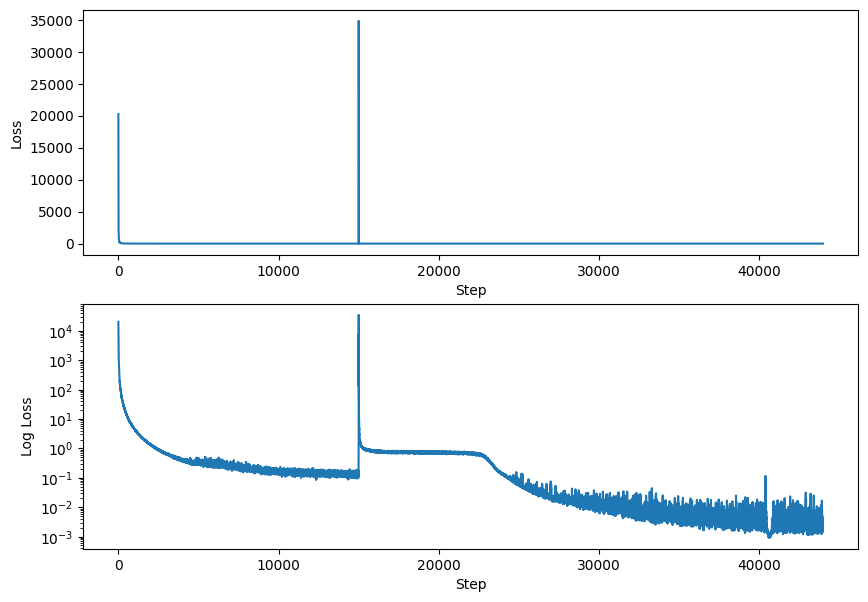

In [51]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(loss_valores)
plt.xlabel("Step"); plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Log Loss")

Dimensiones: us = 400 x 400
x: -1.000 a 1.000
t: 0.000 a 1.000


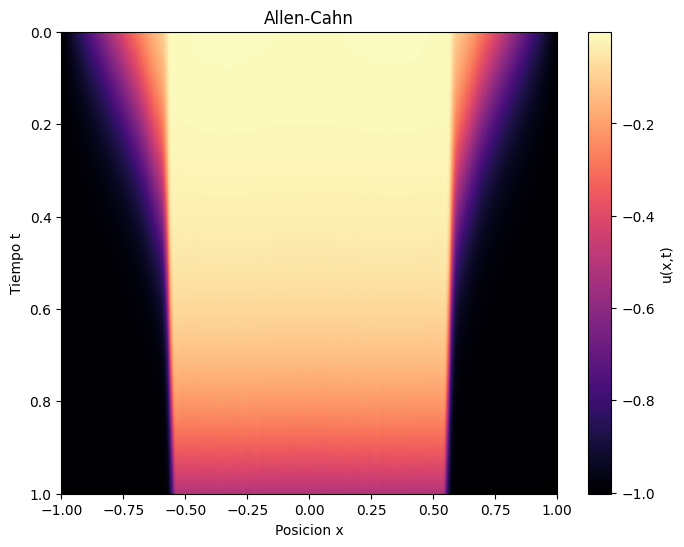

In [ ]:
a = 1.0
t_max = a

with torch.no_grad():
    us = []
    xg = torch.linspace(-a, a, 400, device=device).view(-1, 1)
    
    
    t_range = torch.linspace(0.0, t_max, 400, device=device)  
    
    for i in range(400):
        tg = torch.full_like(xg, t_range[i])  
        
        U = u(xg, tg).squeeze().detach().cpu().numpy()
        us.append(U)
    
    
    x = xg.detach().cpu().numpy().ravel()
    t = t_range.detach().cpu().numpy().ravel()

print(f"Dimensiones: us = {len(us)} x {len(us[0])}")
print(f"x: {x.min():.3f} a {x.max():.3f}")
print(f"t: {t.min():.3f} a {t.max():.3f}")


us_array = np.array(us)  

plt.figure(figsize=(8, 6))
plt.imshow(us_array, 
           extent=[x.min(), x.max(), t.min(), t.max()], 
           aspect='auto', 
           cmap='magma',)  
plt.colorbar(label='u(x,t)')
plt.xlabel('Posicion x')
plt.ylabel('Tiempo t')
plt.title('Allen-Cahn')
plt.show()
plt.show()